<a href="https://colab.research.google.com/github/sanaalshboul/Speech-Geender-Recognition/blob/master/Train_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import Google drive
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#import the required libraries
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa
import librosa.display

from sklearn.metrics import classification_report, confusion_matrix


from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,  Conv1D, MaxPooling1D, Flatten,InputLayer
from keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.wrappers.scikit_learn import KerasClassifier



In [ ]:
#unzip Speech Accent Archive dataset
#for dataset downloaing: https://www.kaggle.com/rtatman/speech-accent-archive?select=speakers_all.csv
!unzip "/content/drive/My Drive/4114_6391_bundle_archive.zip" -d "/content/drive/My Drive/speechAccent"

In [ ]:
#change the current working directory to the dataset directory
import os
os.chdir("/content/drive/My Drive/speechAccent")
!ls

data	reading-passage.txt  speakers_all.csv
images	recordings	     Untitled1.ipynb


In [ ]:
#Explanatory Data Analysis (EDA)
#EDA, reading the dataset metadata
df=pd.read_csv("speakers_all.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              2172 non-null   float64
 1   age_onset        2172 non-null   float64
 2   birthplace       2168 non-null   object 
 3   filename         2172 non-null   object 
 4   native_language  2172 non-null   object 
 5   sex              2172 non-null   object 
 6   speakerid        2172 non-null   int64  
 7   country          2167 non-null   object 
 8   file_missing?    2172 non-null   bool   
 9   Unnamed: 9       0 non-null      float64
 10  Unnamed: 10      0 non-null      float64
 11  Unnamed: 11      1 non-null      object 
dtypes: bool(1), float64(4), int64(1), object(6)
memory usage: 188.9+ KB


,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN


In [ ]:
#data cleaning, rename a column name( file_missing?)
df.rename(columns={"file_missing?" : "file_missing"}, inplace=True)

In [ ]:
#data cleaning, find out the gender types and execluding types otherthan male and female
print(df['sex'].unique())
print(df['file_missing'].unique())

['male' 'female' 'famale']
[ True False]


In [ ]:
#data cleaning, removing rows where the audio file is not exist or the sex is famale then droping the "file_missing" column
df.drop(df[ (df['file_missing'] == True) | (df['sex'] == 'famale')| (df['age'] == 0)].index, inplace = True) 
df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2135 entries, 32 to 2171
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              2135 non-null   float64
 1   age_onset        2135 non-null   float64
 2   birthplace       2135 non-null   object 
 3   filename         2135 non-null   object 
 4   native_language  2135 non-null   object 
 5   sex              2135 non-null   object 
 6   speakerid        2135 non-null   int64  
 7   country          2134 non-null   object 
 8   file_missing     2135 non-null   bool   
 9   Unnamed: 9       0 non-null      float64
 10  Unnamed: 10      0 non-null      float64
 11  Unnamed: 11      1 non-null      object 
dtypes: bool(1), float64(4), int64(1), object(6)
memory usage: 202.2+ KB


The speakers' ages range between  6.0 and 97.0 



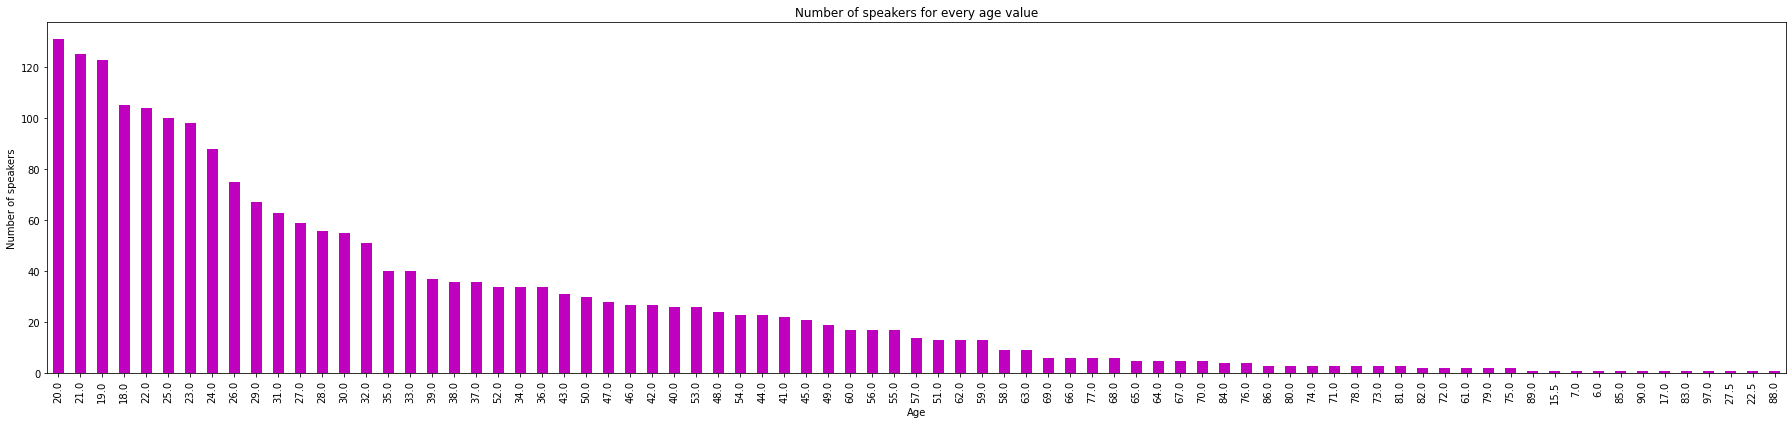

In [ ]:
#EDA, ages of the speakers

ages=df['age']
print("The speakers\' ages range between ", ages.min(), "and", ages.max(), "\n")

period=ages.value_counts()
plt.figure(figsize=(25, 6))
period.plot.bar(color="m")
plt.ylabel('Number of speakers')
plt.xlabel("Age")
plt.title('Number of speakers for every age value')

plt.tight_layout()

dirname="images"

if not os.path.isdir(dirname):
      os.makedirs(dirname)

plt.savefig(f"{dirname}/age.png")

plt.show()

In [ ]:
#EDA, number of languages, number of utterances, length of utterances
languages = df['native_language'].unique()
print("Number of languages in the dataset: ", len(languages), "\n")

print("Number of utterances in the data set is: 1 \n")

textfile = open('reading-passage.txt', 'r')
utterance = textfile.read()

print("The used utterance in the dataset is: ", '\"', utterance, '\"')

print("\n length of the utterance: ", len(utterance.split(" ")), "words")

Number of languages in the dataset:  201 

Number of utterances in the data set is: 1 

The used utterance in the dataset is:  " Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.
 "

 length of the utterance:  73 words


male      1101
female    1034
Name: sex, dtype: int64


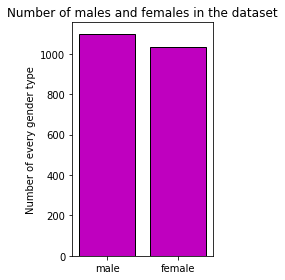

In [ ]:
categories= df['sex'].value_counts()

num_male=categories["male"]
num_female=categories["female"]

print(categories)

# Initialize the plot
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(121)

# Plot the data
ax1.bar(["male","female"],[num_male,num_female], color="m", edgecolor="k")
ax1.set_ylabel('Number of every gender type')
ax1.set_title("Number of males and females in the dataset")

plt.tight_layout()

plt.savefig(f"{dirname}/gender.png")

# Show the plot
plt.show()

In [ ]:
#data cleaning, finding out the desired columns from speakers_all.csv file 
#filename: audio file name, sex: gender for th participant, file_missing?: True if the audio file is missing in the recorded audio and False if the audio file is exist
col=['filename', 'sex', 'file_missing']
df=df[col]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2135 entries, 32 to 2171
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   filename      2135 non-null   object
 1   sex           2135 non-null   object
 2   file_missing  2135 non-null   bool  
dtypes: bool(1), object(2)
memory usage: 52.1+ KB


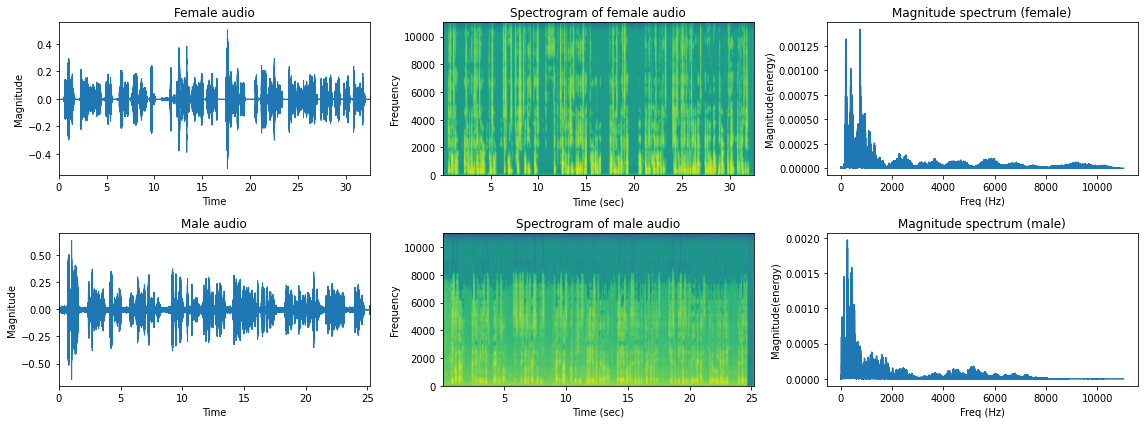

In [ ]:
female_audio,sample_rate1=librosa.core.load('/content/drive/My Drive/speechAccent/recordings/recordings/arabic11.mp3')
male_audio, sample_rate2=librosa.core.load('/content/drive/My Drive/speechAccent/recordings/recordings/akan1.mp3')

t = np.arange(len(female_audio)) / float(sample_rate1)
t2 = np.arange(len(male_audio)) / float(sample_rate2)

dirname="images"

if not os.path.isdir(dirname):
      os.makedirs(dirname)

plt.figure(figsize=(16,6))
plt.subplot(231)
librosa.display.waveplot(female_audio,sample_rate1,max_points=50000.0, x_axis='time', offset=0.0, max_sr=1000)
plt.ylabel('Magnitude')
plt.title("Female audio")

plt.subplot(232)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(female_audio, Fs=sample_rate1)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency')
plt.title('Spectrogram of female audio')

plt.subplot(233)
plt.magnitude_spectrum(female_audio, Fs = sample_rate1) 
plt.xlabel('Freq (Hz)')
plt.ylabel('Magnitude(energy)')
plt.title("Magnitude spectrum (female)")

plt.subplot(234)
librosa.display.waveplot(male_audio,sample_rate2, max_points=50000.0, x_axis='time', offset=0.0, max_sr=1000)
plt.ylabel('Magnitude')
plt.title("Male audio")

plt.subplot(235)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(male_audio, Fs=sample_rate2)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency')
plt.title("Spectrogram of male audio")

plt.subplot(236)
plt.magnitude_spectrum(male_audio, Fs = sample_rate2) 
plt.xlabel('Freq (Hz)')
plt.ylabel('Magnitude(energy)')
plt.title("Magnitude spectrum (male)")

plt.tight_layout()

plt.savefig(f"{dirname}/spectrum.png")

plt.show()   

In [ ]:
#a method for extracting a feature voice.
#example: feature= feature_extraction("path/to/audiofie", "tonnetz")
#params
#feature_name: ["mfcc", "mel", "chroma", "tonnetz", "contrast"]
#file_name: path to the audio file
def feature_extraction(file_name, featuer_name):
  

  audio, sample_rate = librosa.core.load(file_name)
  EnrgSpectra = np.abs(librosa.stft(audio))
  result=np.asarray(())

  if featuer_name=="mfcc":
    features=np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=25).T, axis=0)
    #rescale the data
    features=preprocessing.scale(features)
    #stack the feature arrays in a horizantal numpy array
    features=np.hstack((result,features))

  if featuer_name=="chroma":
    chroma=np.mean(librosa.feature.chroma_stft(S=EnrgSpectra, sr=sample_rate).T, axis=0)
    chroma=preprocessing.scale(chroma)
    features=np.hstack((result,chroma))
  
  if featuer_name=="mel":
    mel = np.mean(librosa.feature.melspectrogram(audio, sr=sample_rate).T, axis=0)
    mel=preprocessing.scale(mel)
    features=np.hstack((result,mel))

  if featuer_name=="tonnetz":
    tonnetz=np.mean(librosa.feature.tonnetz(y=audio,sr=sample_rate).T, axis=0)
    tonnetz=preprocessing.scale(tonnetz)
    features=np.hstack((result,tonnetz))
  if featuer_name=="contrast":
    contrast=np.mean(librosa.feature.spectral_contrast(y=audio,sr=sample_rate).T, axis=0)
    contrast=preprocessing.scale(contrast)
    features=np.hstack((result,contrast))
 
    
  return features

In [ ]:
featureList=list()
label=list()


for i ,(filename, sex) in enumerate(zip(df['filename'], df['sex'])):
  path='recordings/recordings/' + filename + ".mp3"
  if os.path.isfile("./"+path):
    features=feature_extraction(path, "mel")
    featureList.append(features)
    if sex=='female':
      label.append(1)
    else: 
      label.append(0)
  else: 
    continue

Y=np.array(label).reshape(len(label),1)
X=np.array(featureList).reshape(len(featureList), len(features))

dirname="data"

if not os.path.isdir(dirname):
  os.makedir(dirname)

np.save("all_audio_features", X)
np.save("all_labels", Y)


In [ ]:
#method for loaing the features and labels for all audio files
def load_data():
  X=np.load("/content/drive/My Drive/speechAccent/data/all_audio_features.npy")
  Y=np.load("/content/drive/My Drive/speechAccent/data/all_labels.npy")
  
  return X, Y

In [ ]:
#loading the dataset
X,Y=load_data()

#splitting the data into 70% training, 15% validation, 15% testing sets
X_train, X_test, Y_train, Y_test= train_test_split(X,Y, test_size=0.30, random_state=42, shuffle=True)
X_vald, X_test, Y_vald, Y_test= train_test_split(X_test,Y_test, test_size=0.50, random_state=10, shuffle=True)
np.random.seed(5)

In [ ]:
#hyperparameters finetuning for MLPClassifier using GridSearchCV algorithm
param_grid = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
mlp=MLPClassifier()
mlp_cv=GridSearchCV(mlp, param_grid, cv=10)
mlp_cv.fit(X_train, Y_train.ravel())

#model_name="mfcc_model.sav"
#pickle.dump(xgb_cv, open(model_name, 'wb'))

print(mlp_cv.best_params_)
print(mlp_cv.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'sgd'}
0.9030380313199105


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:

mlp = MLPClassifier(hidden_layer_sizes=(10,30,10), activation='relu', alpha=0.0001, learning_rate='constant', solver='sgd', learning_rate_init=0.001, random_state=5).fit(X_train,Y_train.ravel() )
Y_pred=mlp.predict(X_test)

print(accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))


0.9314641744548287
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       164
           1       0.91      0.95      0.93       157

    accuracy                           0.93       321
   macro avg       0.93      0.93      0.93       321
weighted avg       0.93      0.93      0.93       321



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
#hyperparameters tuning for a created NN model

learning_rate = 0.00001
momentum = 0.8

#initialize optimizer
opt = Adam(lr=learning_rate)

def create_model(init_mode='uniform'):
    vector_length=128

    model = Sequential()
    model.add(Dense(256, kernel_initializer=init_mode,input_shape=(vector_length,)))
    model.add(Dense(256,kernel_initializer=init_mode, activation="relu"))
    #model.add(Dropout(0.3))
    model.add(Dense(256, kernel_initializer=init_mode,activation="relu"))
    #model.add(Dropout(0.3))
    model.add(Dense(256,kernel_initializer=init_mode, activation="relu"))
    #model.add(Dropout(0.3))
    model.add(Dense(128, kernel_initializer=init_mode,activation="relu"))
    model.add(Dropout(0.3))
    # one output neuron with sigmoid activation function, 0 means female, 1 means male
    model.add(Dense(1, kernel_initializer=init_mode,activation="sigmoid"))
    # using binary crossentropy as it's male/female classification (binary)
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=opt)
   
    return model


model_CV = KerasClassifier(build_fn=create_model, verbose=1)

# define the grid search parameters
init_mode = ['glorot_uniform' ,'lecun_uniform']
batches = [10]
epochs = [20, 90]

param_grid = dict(epochs=epochs, batch_size=batches,init_mode=init_mode)

grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(X_train, Y_train)

#print the best hyperparameters' values of the model
print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')


Epoch 1/90
150/150 [==============================] - 1s 3ms/step - loss: 0.6728 - accuracy: 0.6000
Epoch 2/90
150/150 [==============================] - 0s 3ms/step - loss: 0.6041 - accuracy: 0.7585
Epoch 3/90
150/150 [==============================] - 0s 3ms/step - loss: 0.5298 - accuracy: 0.7993
Epoch 4/90
150/150 [==============================] - 1s 3ms/step - loss: 0.4637 - accuracy: 0.8100
Epoch 5/90
150/150 [==============================] - 1s 4ms/step - loss: 0.4123 - accuracy: 0.8361
Epoch 6/90
150/150 [==============================] - 1s 3ms/step - loss: 0.3781 - accuracy: 0.8542
Epoch 7/90
150/150 [==============================] - 1s 3ms/step - loss: 0.3531 - accuracy: 0.8535
Epoch 8/90
150/150 [==============================] - 1s 3ms/step - loss: 0.3286 - accuracy: 0.8749
Epoch 9/90
150/150 [==============================] - 1s 4ms/step - loss: 0.3116 - accuracy: 0.8763
Epoch 10/90
150/150 [==============================] - 1s 4ms/step - loss: 0.2928 - accuracy: 0.8823

In [ ]:

#train and test the model using the best parameters
learning_rate = 0.00001
momentum = 0.8

opt = Adam(lr=learning_rate)

def create_model(init_mode='lecun_uniform'):
    vector_length=128
    """5 hidden dense layers from 256 units to 64, not the best model."""
    model = Sequential()
    model.add(Dense(256, kernel_initializer=init_mode,input_shape=(vector_length,)))
    model.add(Dense(256,kernel_initializer=init_mode, activation="relu"))
    #model.add(Dropout(0.3))
    model.add(Dense(256, kernel_initializer=init_mode,activation="relu"))
    #model.add(Dropout(0.3))
    model.add(Dense(256,kernel_initializer=init_mode, activation="relu"))
    #model.add(Dropout(0.3))
    model.add(Dense(128, kernel_initializer=init_mode,activation="relu"))
    model.add(Dropout(0.3))
    # one output neuron with sigmoid activation function, 0 means female, 1 means male
    model.add(Dense(1, kernel_initializer=init_mode,activation="sigmoid"))
    # using binary crossentropy as it's male/female classification (binary)
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=opt)
    # print summary of the model
   
    return model


model=create_model()

model.fit(X_train,Y_train,validation_data=(X_vald,Y_vald), batch_size=10, epochs=90, verbose=1)

loss, accuracy = model.evaluate(X_test, Y_test, verbose=1)
print("Loss:", loss)
print("Accuracy: ",accuracy*100)


Epoch 1/90
150/150 [==============================] - 1s 4ms/step - loss: 0.6673 - accuracy: 0.5732 - val_loss: 0.6205 - val_accuracy: 0.7913
Epoch 2/90
150/150 [==============================] - 0s 3ms/step - loss: 0.6008 - accuracy: 0.7231 - val_loss: 0.5488 - val_accuracy: 0.8567
Epoch 3/90
150/150 [==============================] - 0s 3ms/step - loss: 0.5304 - accuracy: 0.8013 - val_loss: 0.4733 - val_accuracy: 0.8723
Epoch 4/90
150/150 [==============================] - 0s 3ms/step - loss: 0.4659 - accuracy: 0.8395 - val_loss: 0.4072 - val_accuracy: 0.8816
Epoch 5/90
150/150 [==============================] - 0s 3ms/step - loss: 0.4107 - accuracy: 0.8468 - val_loss: 0.3603 - val_accuracy: 0.8941
Epoch 6/90
150/150 [==============================] - 0s 3ms/step - loss: 0.3745 - accuracy: 0.8595 - val_loss: 0.3280 - val_accuracy: 0.9065
Epoch 7/90
150/150 [==============================] - 0s 3ms/step - loss: 0.3521 - accuracy: 0.8696 - val_loss: 0.3044 - val_accuracy: 0.9065
Epoch 